In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from copy import deepcopy
import numpy as np
import torch
import wandb
from torch.utils.data import DataLoader
from src.dataload.window_based import WindowBasedDataset, WeightedWindowBasedDataset
from src.dataload.tabular import tabularDataset, WeightedtabularDataset


def _softmax(recon_error):
    exp_recon_error = np.exp(recon_error - np.max(recon_error))
    return exp_recon_error / np.sum(exp_recon_error)


def _cal_sample_weight(recon_error):
    sample_weight = 1 - _softmax(recon_error)
    sample_weight = sample_weight / np.sum(sample_weight)
    return sample_weight


class BaseTrainer:
    def __init__(self, model, optimizer, crit):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.crit = crit

    def _train(self, train_loader, device):
        self.model.train()
        total_loss = 0
        for input_x, _ in train_loader:
            if device != "cpu":
                input_x = input_x.to(device)
                output_x = input_x.to(device)
            y_hat = self.model(input_x)
            loss = self.crit(y_hat, output_x)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # prevent memory leak
            total_loss += float(loss)
        return total_loss / len(train_loader)

    def _validate(self, val_loader, device):
        self.model.eval()
        with torch.no_grad():
            total_loss = 0
            for input_x, _ in val_loader:
                if device != "cpu":
                    input_x = input_x.to(device)
                    output_x = input_x.to(device)
                y_hat = self.model(input_x)
                loss = self.crit(y_hat, output_x)
                # prevent memory leak
                total_loss += float(loss)
            return total_loss / len(val_loader)

    def train(self, train_loader, val_loader, config, use_wandb):
        lowest_train_loss = np.inf
        lowest_val_loss = np.inf
        best_model = None
        early_stop_round = 0
        return_epoch = 0

        if use_wandb:
            wandb.login()
            wandb.init(project=config.project, config=config)
            wandb.watch(self.model, self.crit, log="gradients", log_freq=100)

        for epoch_index in range(config.n_epochs):
            train_loss = self._train(train_loader, config.device)
            valid_loss = self._validate(val_loader, config.device)

            if use_wandb:
                wandb.log({"train_loss": train_loss})
                wandb.log({"valid_loss": valid_loss})

            if valid_loss < lowest_val_loss:
                lowest_train_loss = train_loss
                lowest_val_loss = valid_loss
                best_model = deepcopy(self.model.state_dict())
                early_stop_round = 0
            else:
                early_stop_round += 1
            if early_stop_round == config.early_stop_round:
                # print(f"Early Stopped! in Epoch {epoch_index + 1}:")
                # print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
                return_epoch = epoch_index
                break
            # if (epoch_index + 1) % 10 == 0:
                # print(f"Epoch {epoch_index+1}/{config.n_epochs}:")
                # print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
            return_epoch = epoch_index
        self.model.load_state_dict(best_model)
        return lowest_train_loss, lowest_val_loss, return_epoch, self.model


class NewTrainer:
    def __init__(self, model, optimizer, crit):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.crit = crit

    def _train(self, train_loader, device):
        self.model.train()
        total_loss = 0
        for input_x, _ in train_loader:
            if device != "cpu":
                input_x = input_x.to(device)
                output_x = input_x.to(device)
            y_hat = self.model(input_x)
            loss = self.crit(y_hat, output_x)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += float(loss)
        return total_loss / len(train_loader)

    def _validate(self, val_loader, device):
        self.model.eval()
        with torch.no_grad():
            total_loss = 0
            for input_x, _ in val_loader:
                if device != "cpu":
                    input_x = input_x.to(device)
                    output_x = input_x.to(device)
                y_hat = self.model(input_x)
                loss = self.crit(y_hat, output_x)
                # prevent memory leak
                total_loss += float(loss)
            return total_loss / len(val_loader)

    def _inference(self, train_loader, train_recon_error, config):
        self.model.eval()
        idx = 0
        with torch.no_grad():
            for input_x, _ in train_loader:
                input_x_batch_size = input_x.shape[0]
                if config.device != "cpu":
                    input_x = input_x.to(config.device)
                y_hat = self.model(input_x)
                # calculate train recon error
                anomaly_score = abs(input_x - y_hat)
                mean_anomaly_score = (
                    torch.mean(anomaly_score, 1).detach().to("cpu").numpy()
                )
                train_recon_error[idx : idx + input_x_batch_size] = mean_anomaly_score
                idx += input_x_batch_size
        return train_recon_error

    def train(
        self,
        train_x,
        train_y,
        train_loader,
        val_loader,
        sampling_term,
        initial_epochs,
        config,
        use_wandb,
    ):
        lowest_train_loss = np.inf
        lowest_val_loss = np.inf
        best_model = None
        early_stop_round = 0
        return_epoch = 0

        if config.data == "tabular":
            data_len = len(train_x)
        else:
            data_len = len(train_x) - config.window_size + 1
        train_recon_error = np.zeros(data_len)
        sample_weights = np.zeros((data_len, config.n_epochs))
        sample_weight_idx = 0

        if use_wandb:
            wandb.login()
            wandb.init(project=config.project, config=config)
            wandb.watch(self.model, self.crit, log="gradients", log_freq=100)

        for epoch_index in range(config.n_epochs):
            # sampling
            if (epoch_index >= initial_epochs - 1) and (
                epoch_index % sampling_term == 0
            ):
                train_loss = self._train(train_loader, config.device)
                valid_loss = self._validate(val_loader, config.device)

                # calculate weight
                ## make dataloader for inference
                if config.data == "tabular":
                    train_dataset = tabularDataset(train_x, train_y)
                else:
                    train_dataset = WindowBasedDataset(
                        train_x, train_y, config.window_size
                    )
                train_loader_for_inference = DataLoader(
                    train_dataset, shuffle=False, batch_size=config.batch_size
                )
                ## inference to get train reconstruction error
                train_recon_error = self._inference(
                    train_loader_for_inference, train_recon_error, config
                )
                ## calculdate sample weight
                sample_weight = _cal_sample_weight(train_recon_error)
                sample_weights[:, sample_weight_idx] = sample_weight
                sample_weight_idx += 1

                # sampling with weight
                if config.data == "tabular":
                    train_dataset = WeightedtabularDataset(
                        train_x, train_y, sample_weight
                    )
                else:
                    train_dataset = WeightedWindowBasedDataset(
                        train_x, train_y, config.window_size, sample_weight
                    )
                train_loader = DataLoader(
                    train_dataset, shuffle=False, batch_size=config.batch_size
                )
            # no sampling
            else:
                train_loss = self._train(train_loader, config.device)
                valid_loss = self._validate(val_loader, config.device)

            if use_wandb:
                wandb.log({"train_loss": train_loss})
                wandb.log({"valid_loss": valid_loss})

            if valid_loss < lowest_val_loss:
                lowest_train_loss = train_loss
                lowest_val_loss = valid_loss
                best_model = deepcopy(self.model.state_dict())
                early_stop_round = 0
            else:
                early_stop_round += 1
            if early_stop_round == config.early_stop_round:
                # print(f"Early Stopped! in Epoch {epoch_index + 1}:")
                # print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
                return_epoch = epoch_index
                break
            # if (epoch_index + 1) % 10 == 0:
                # print(f"Epoch {epoch_index+1}/{config.n_epochs}:")
                # print(f"train_loss={train_loss:.3f}, valid_loss={valid_loss:.3f}")
            return_epoch = epoch_index
        self.model.load_state_dict(best_model)
        return lowest_train_loss, lowest_val_loss, return_epoch, self.model, sample_weights


C:\Users\ghktj\anaconda3\envs\pytorch\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
X, y = make_classification(n_samples=5000, n_features=8, n_informative=8, n_redundant=0,  n_classes=2, weights=[0.9,0.1], random_state=0)

In [4]:
X2, y2 = make_classification(n_samples=10000, n_features=8, n_informative=8, n_redundant=0,  n_classes=2, weights=[0.9,0.1], random_state=0)

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=5)

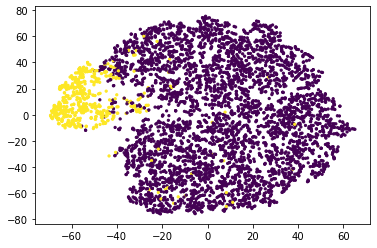

In [5]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=5)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def _normalize_tabular(df: pd.DataFrame, label_name: str = "label"):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(label_name, axis=1))
    y = df[label_name]
    return X, y

def simul_split_train_valid_test(df: pd.DataFrame, train_ratio: float = 0.7):
    X, y = _normalize_tabular(df)
    tmp = pd.DataFrame(X)
    tmp["label"] = y
    normal = tmp.loc[tmp["label"] == 0, :].reset_index(drop=True)
    abnormal = tmp.loc[tmp["label"] == 1, :].reset_index(drop=True)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        normal.drop("label", axis=1),
        normal["label"],
        train_size=train_ratio,
        random_state=42,
        shuffle=False,
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=42, shuffle=False
    )
    X_test["label"] = y_test
    X_test = pd.concat([X_test, abnormal])
    return (
        X_train.values,
        X_val.values,
        X_test.drop("label", axis=1).values,
        y_train.values,
        y_val.values,
        X_test["label"].values,
    )

In [6]:
def contamination(X, y, ratio):
    tmp_df = pd.DataFrame(X)
    tmp_df['label'] = y
    normal = tmp_df.loc[tmp_df['label'] == 0, :].reset_index(drop=True)
    abnormal = tmp_df.loc[tmp_df['label'] == 1, :].reset_index(drop=True)
    idx = np.arange(len(abnormal))
    num_contamination = int(ratio * len(abnormal))
    np.random.seed(0)
    choice_idx = np.random.choice(idx, num_contamination, replace=False)
    normal.iloc[choice_idx, :-1] = (normal.iloc[choice_idx, :-1] + abnormal.iloc[choice_idx, :-1]) / 2
    result_df = pd.concat([normal, abnormal]).reset_index(drop=True)
    return len(choice_idx), result_df

In [7]:
normal_df = pd.DataFrame(X)
normal_df['label'] = y
num_dirty_10, dirty_df_10 = contamination(X, y, 0.1)
per_10 = num_dirty_10 / len(dirty_df_10.loc[dirty_df_10['label'] == 0, :])
num_dirty_20, dirty_df_20 = contamination(X, y, 0.5)
per_20 = num_dirty_20 / len(dirty_df_20.loc[dirty_df_20['label'] == 0, :])
num_dirty_30, dirty_df_30 = contamination(X, y, 0.9)
per_30 = num_dirty_30 / len(dirty_df_30.loc[dirty_df_30['label'] == 0, :])

print(f'ratio=0.1 : {num_dirty_10}, {per_10}')
print(f'ratio=0.2 : {num_dirty_20}, {per_20}')
print(f'ratio=0.3 : {num_dirty_30}, {per_30}')

ratio=0.1 : 51, 0.01137123745819398
ratio=0.2 : 257, 0.05730211817168339
ratio=0.3 : 463, 0.1032329988851728


In [8]:
normal_df2 = pd.DataFrame(X2)
normal_df2['label'] = y2
num_dirty_10_2, dirty_df_10_2 = contamination(X2, y2, 0.1)
per_10 = num_dirty_10_2 / len(dirty_df_10_2.loc[dirty_df_10_2['label'] == 0, :])
num_dirty_20_2, dirty_df_20_2 = contamination(X2, y2, 0.5)
per_20 = num_dirty_20_2 / len(dirty_df_20_2.loc[dirty_df_20_2['label'] == 0, :])
num_dirty_30_2, dirty_df_30_2 = contamination(X2, y2, 0.9)
per_30 = num_dirty_30_2 / len(dirty_df_30_2.loc[dirty_df_30_2['label'] == 0, :])

print(f'ratio=0.1 : {num_dirty_10_2}, {per_10}')
print(f'ratio=0.2 : {num_dirty_20_2}, {per_20}')
print(f'ratio=0.3 : {num_dirty_30_2}, {per_30}')

ratio=0.1 : 104, 0.011618813540386548
ratio=0.2 : 524, 0.05854094514579376
ratio=0.3 : 944, 0.10546307675120098


In [9]:
filp_X_1, filp_y_1 = make_classification(n_samples=5000, n_features=8, n_informative=8, n_redundant=0,  n_classes=2, weights=[0.9,0.1], random_state=0, flip_y =0.1)
filp_X_05, filp_y_05 = make_classification(n_samples=5000, n_features=8, n_informative=8, n_redundant=0,  n_classes=2, weights=[0.9,0.1], random_state=0, flip_y =0.05)

flip_df_1 = pd.DataFrame(filp_X_1)
flip_df_1['label'] = filp_y_1

flip_df_05 = pd.DataFrame(filp_X_05)
flip_df_05['label'] = filp_y_05

In [10]:
torch.backends.cudnn.deterministic = True
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [11]:
from argparse import Namespace

config = {
    'trainer_name' : 'BaseTrainer',
    'train_ratio': .7,
    'batch_size': 256,
    'n_epochs': 1000,
    'early_stop_round': 30,
    'hidden_size': [2],
    'window_size': 60,
    'data': 'tabular',
    # 'sampling_term': [1, 4, 16],
    'sampling_term': [1],
    'initial_epochs': [10]
    # 'initial_epochs': [10]
}

# gpu
gpu_id = 0 if torch.cuda.is_available() else -1

if gpu_id == 0:
    config['device'] = 'cuda:0'
else:
    config['device'] = 'cpu'

config = Namespace(**config)

print(config)

Namespace(batch_size=256, data='tabular', device='cuda:0', early_stop_round=30, hidden_size=[2], initial_epochs=[20], n_epochs=1000, sampling_term=[1], train_ratio=0.7, trainer_name='BaseTrainer', window_size=60)


In [12]:

from src.models.BaseAutoEncoder import BaseSeq2Seq
from src.dataload.tabular import tabularDataset
from src.utils import inference

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import random

In [13]:
# normal_df
# dirty_df_10, dirty_df_20, dirty_df_30

# flip_df_1, flip_df_05

# normal_df2
# dirty_df_10_2, dirty_df_20_2, dirty_df_30_2

config.data_name = "dirty_df_30_2_test"

(
    train_x,
    valid_x,
    test_x,
    train_y,
    valid_y,
    test_y,
) = simul_split_train_valid_test(dirty_df_30_2, config.train_ratio)
# resize 'window_size' = 'col_len'
config.window_size = train_x.shape[1]

train_dataset = tabularDataset(train_x, train_y)
valid_dataset = tabularDataset(valid_x, valid_y)

train_dataloader = DataLoader(
    train_dataset, shuffle=False, batch_size=config.batch_size
)
valid_dataloader = DataLoader(
    valid_dataset, shuffle=False, batch_size=config.batch_size
)

total_x = np.concatenate([train_x, valid_x, test_x])
total_y = np.concatenate([train_y, valid_y, test_y])
IR = round((len(total_y) - np.sum(total_y)) / np.sum(total_y), 4)
# for inference
total_dataset = tabularDataset(total_x, total_y)
total_dataloader = DataLoader(
    total_dataset, shuffle=False, batch_size=config.batch_size
)

for hidden_size in config.hidden_size:
    print(f"-----BaseTrainer starts with hidden_size={hidden_size}-----")
    config.trainer_name = "BaseTrainer"

    model = BaseSeq2Seq(
        input_size=config.window_size,
        hidden_size=hidden_size,
        output_size=config.window_size,
        dropout_p=0.2,
    ).to(config.device)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    # train
    trainer = BaseTrainer(model=model, optimizer=optimizer, crit=criterion)

    train_loss, val_loss, return_epoch, best_model = trainer.train(
        train_loader=train_dataloader,
        val_loader=valid_dataloader,
        config=config,
        use_wandb=False,
    )

    best_model.to("cpu")
    sampling_term = 0
    PATH = "./run_results_sim/"
    df = inference(
        config,
        total_dataloader,
        best_model,
        train_x,
        valid_x,
        total_x,
        total_y,
        return_epoch,
        hidden_size,
        train_loss,
        val_loss,
        IR,
        sampling_term,
        PATH
    )

    df.to_csv(PATH + "result_" + config.data_name + ".csv", index=False)

for initial_epochs in config.initial_epochs: 
    for hidden_size in config.hidden_size:
                for sampling_term in config.sampling_term:
                    print(
                        f"-----NewTrainer starts with hidden_size={hidden_size}, sampling_term={sampling_term}-----"
                    )
                    config.trainer_name = "NewTrainer"

                    model = BaseSeq2Seq(
                        input_size=config.window_size,
                        hidden_size=hidden_size,
                        output_size=config.window_size,
                        dropout_p=0.2,
                    ).to(config.device)

                    optimizer = optim.Adam(model.parameters())
                    criterion = nn.MSELoss()

                    # train
                    trainer = NewTrainer(model=model, optimizer=optimizer, crit=criterion)

                    train_loss, val_loss, return_epoch, best_model, sample_weights = trainer.train(
                        train_x=train_x,
                        train_y=train_y,
                        train_loader=train_dataloader,
                        val_loader=valid_dataloader,
                        config=config,
                        sampling_term=sampling_term,
                        initial_epochs=initial_epochs,
                        use_wandb=False,
                    )

                    best_model.to("cpu")

                    df = inference(
                        config,
                        total_dataloader,
                        best_model,
                        train_x,
                        valid_x,
                        total_x,
                        total_y,
                        return_epoch,
                        hidden_size,
                        train_loss,
                        val_loss,
                        IR,
                        sampling_term,
                        PATH
                    )

                    df.to_csv(PATH + "result_" + config.data_name + ".csv", index=False)

<ipython-input-5-2e5b80c201c4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


-----BaseTrainer starts with hidden_size=2-----
New file generated!
-----NewTrainer starts with hidden_size=2, sampling_term=1-----


In [14]:
def _softmax(recon_error):
    exp_recon_error = np.exp(recon_error - np.max(recon_error))
    return exp_recon_error / np.sum(exp_recon_error)


def cal_sample_weight(recon_error):
    sample_weight = 1 - _softmax(recon_error)
    sample_weight = sample_weight / np.sum(sample_weight)
    return sample_weight

(array([ 14.,  82., 190., 320., 427., 559., 516., 553., 515., 450., 421.,
        337., 299., 273., 210., 182., 152., 118., 107.,  77.,  85.,  68.,
         48.,  48.,  38.,  33.,  26.,  18.,  10.,  14.,  19.,   6.,   7.,
          7.,   2.,   8.,   3.,   7.,   5.,   1.,   0.,   1.,   1.,   1.,
          2.,   0.,   1.,   1.,   1.,   2.]),
 array([0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.00015962, 0.00015962,
        0.00015962, 0.00015962, 0.00015962, 0.

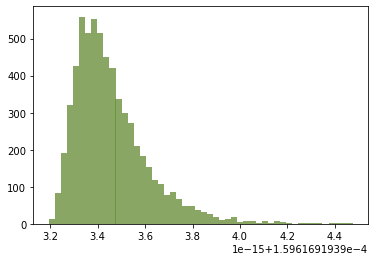

In [32]:
w0 = cal_sample_weight(sample_weights[:, 0])
plt.hist(w0, bins=50, alpha=0.4)
w100 = cal_sample_weight(sample_weights[:, 100])
plt.hist(w0, bins=50, alpha=0.4)
w300 = cal_sample_weight(sample_weights[:, 300])
plt.hist(w0, bins=50, alpha=0.4)

In [64]:
remain_data = []
for i in range(sample_weights.shape[1]):
    if sample_weights[:, i].sum() == 0.0:
        continue
    w = cal_sample_weight(sample_weights[:, i])
    result = np.random.choice(np.arange(len(w)), size=len(w), p=w, replace=True)
    remain_data.append(pd.Series(result).nunique())

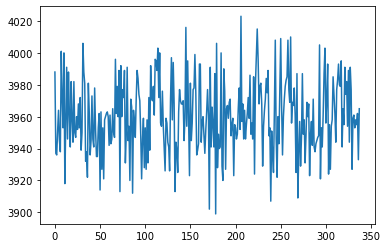

In [65]:
plt.plot(remain_data)

# 노이즈 데이터가 정말 나가리 되는지 시각화 확인
- 일단 지금은 잘 안됨
  - initial epoch를 더 짧게?
- + 반대로 test 데이터에 normal에 가까운 abnormal이 있다면?? 어떻게 될까

In [70]:
tmp_df = pd.DataFrame(X2)
tmp_df['label'] = y2
normal = tmp_df.loc[tmp_df['label'] == 0, :].reset_index(drop=True)
abnormal = tmp_df.loc[tmp_df['label'] == 1, :].reset_index(drop=True)
idx = np.arange(len(abnormal))
num_contamination = int(0.9 * len(abnormal))
np.random.seed(0)
choice_idx = np.random.choice(idx, num_contamination, replace=False)
normal.iloc[choice_idx, :-1] = (normal.iloc[choice_idx, :-1] + abnormal.iloc[choice_idx, :-1]) / 2
result_df = pd.concat([normal, abnormal]).reset_index(drop=True)
result_df['noise'] = 0
result_df.iloc[choice_idx, -1] = 1

In [80]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(result_df.iloc[:, 0:-2])
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=result_df['noise'], s=5)

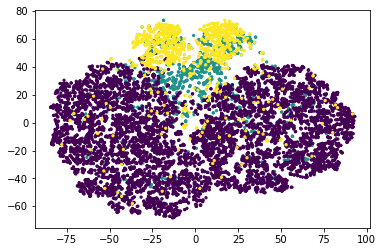

In [83]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=result_df['noise']+result_df['label']*2, s=5)

In [84]:
(
    train_x,
    valid_x,
    test_x,
    train_y,
    valid_y,
    test_y,
) = simul_split_train_valid_test(result_df, 0.7)

<ipython-input-5-2e5b80c201c4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


In [96]:
pd.Series(train_x[:,-1]).value_counts()

-0.322863    5321
 3.097292     944
dtype: int64

- 아래의 경우 noise의 갯수 100번 돌려서 평균내자

In [103]:
w = cal_sample_weight(sample_weights[:, 0])
result = np.random.choice(np.arange(len(w)), size=len(w), p=w, replace=True)
pd.Series(train_x[result,-1]).value_counts()

-0.322863    5330
 3.097292     935
dtype: int64

In [104]:
w = cal_sample_weight(sample_weights[:, 200])
result = np.random.choice(np.arange(len(w)), size=len(w), p=w, replace=True)
pd.Series(train_x[result,-1]).value_counts()

-0.322863    5322
 3.097292     943
dtype: int64

In [105]:
w = cal_sample_weight(sample_weights[:, 300])
result = np.random.choice(np.arange(len(w)), size=len(w), p=w, replace=True)
pd.Series(train_x[result,-1]).value_counts()

-0.322863    5319
 3.097292     946
dtype: int64

In [57]:
# pd.read_csv('./run_results_sim/result_normal_df.csv')

In [60]:
# pd.read_csv('./run_results_sim/result_dirty_df_10.csv')

In [58]:
# pd.read_csv('./run_results_sim/result_dirty_df_20.csv')

In [59]:
# pd.read_csv('./run_results_sim/result_dirty_df_30.csv')

In [61]:
# pd.read_csv('./run_results_sim/result_flip_df_1.csv')

In [62]:
# pd.read_csv('./run_results_sim/result_flip_df_05.csv')

In [63]:
# pd.read_csv('./run_results_sim/result_normal_df2.csv')

In [ ]:
# pd.read_csv('./run_results_sim/result_normal_df2.csv')

In [122]:
df30 = pd.read_csv('./run_results_sim/result_dirty_df_30_2.csv')
df30.groupby(['trainer_name','sampling_term'])[['roc_auc','pr_auc']].mean()

roc_auc    pr_auc
trainer_name sampling_term                    
BaseTrainer  0              0.824600  0.787260
NewTrainer   1              0.835120  0.798680
             4              0.838075  0.802750
             16             0.837725  0.803625

In [123]:
df10 = pd.read_csv('./run_results_sim/result_normal_df2.csv')
df10.groupby(['trainer_name','sampling_term'])[['roc_auc','pr_auc']].mean()

roc_auc    pr_auc
trainer_name sampling_term                    
BaseTrainer  0              0.855850  0.823075
NewTrainer   1              0.862825  0.833050
             4              0.863050  0.832175
             16             0.859600  0.829025

In [126]:
df10 = pd.read_csv('./run_results_sim/result_dirty_df_10_2.csv')
df10.groupby(['trainer_name','sampling_term'])[['roc_auc','pr_auc']].mean()

roc_auc    pr_auc
trainer_name sampling_term                    
BaseTrainer  0              0.857425  0.828050
NewTrainer   1              0.856125  0.823875
             4              0.861475  0.836175
             16             0.858675  0.824625

In [98]:
df10 = pd.read_csv('./run_results_sim/result_dirty_df_10.csv')
df10.groupby(['trainer_name','sampling_term'])[['roc_auc','pr_auc']].mean()

roc_auc   pr_auc
trainer_name sampling_term                   
BaseTrainer  0              0.858925  0.82775
NewTrainer   1              0.856150  0.83250
             4              0.831250  0.80120
             16             0.850750  0.82325

In [100]:
df30 = pd.read_csv('./run_results_sim/result_dirty_df_30.csv')
df30.groupby(['trainer_name','sampling_term'])[['roc_auc','pr_auc']].mean()

roc_auc    pr_auc
trainer_name sampling_term                    
BaseTrainer  0              0.817133  0.782333
NewTrainer   1              0.834667  0.804367
             4              0.801533  0.764400
             16             0.814667  0.782300

{'whiskers': [<matplotlib.lines.Line2D at 0x20cc80a3880>,
 'caps': [<matplotlib.lines.Line2D at 0x20c9a0c6100>,
 'boxes': [<matplotlib.lines.Line2D at 0x20cc80a3b20>],
 'medians': [<matplotlib.lines.Line2D at 0x20cc8080160>],
 'fliers': [<matplotlib.lines.Line2D at 0x20cc8080670>],
 'means': []}

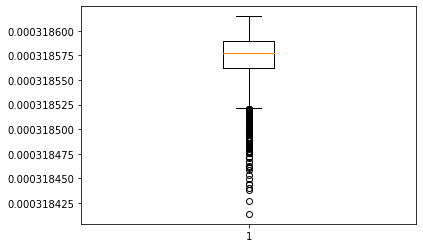

In [104]:
plt.boxplot(sample_weights[:, 0])

{'whiskers': [<matplotlib.lines.Line2D at 0x20ceb071970>,
 'caps': [<matplotlib.lines.Line2D at 0x20ceb07d070>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ceb071670>],
 'medians': [<matplotlib.lines.Line2D at 0x20ceb07d730>],
 'fliers': [<matplotlib.lines.Line2D at 0x20ceb07da30>],
 'means': []}

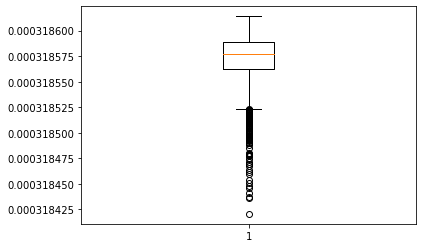

In [114]:
plt.boxplot(sample_weights[:,100])